在了解了线性回归的背景知识之后，现在我们可以动手实现它了。尽管强大的深度学习框架可以减少大量重复性工作，**但若过于依赖它提供的便利，会导致我们很难深入理解深度学习是如何工作的**。因此，本节将介绍如何只利用`Tensor`和`GradientTape`来实现一个线性回归的训练。

首先，导入本节中实验所需的包或模块，其中的matplotlib包可用于作图，且设置成嵌入显示。m

In [1]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)
from matplotlib import pyplot as plt
import random

2.4.1


## 3.2.1 生成数据集

我们构造一个简单的人工训练数据集，它可以使我们能够直观比较学到的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征 $\boldsymbol{X} \in \mathbb{R}^{1000 \times 2}$，我们使用线性回归模型真实权重 $\boldsymbol{w} = [2, -3.4]^\top$ 和偏差 $b = 4.2$，以及一个随机噪声项 $\epsilon$ 来生成标签
$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon
$$

其中噪声项 $\epsilon$ 服从均值为0、标准差为0.01的正态分布。噪声代表了数据集中无意义的干扰。下面，让我们生成数据集。

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2,-3,4]
true_b = 4.2
features = tf.random.normal((num_examples, num_inputs), stddev=1)
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += tf.random.normal(labels.shape, stddev=0.01)

In [3]:
features

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 1.1307405 , -0.42415765],
       [ 0.54542196,  0.8344208 ],
       [ 1.1479864 , -0.8138729 ],
       ...,
       [-1.7813405 , -3.3352308 ],
       [ 0.61578417, -1.7322417 ],
       [-0.01994615, -1.893793  ]], dtype=float32)>

In [4]:
print(features[0], labels[0])

tf.Tensor([ 1.1307405  -0.42415765], shape=(2,), dtype=float32) tf.Tensor(7.726161, shape=(), dtype=float32)


通过生成第二个特征`features[:, 1]`和标签 `labels` 的散点图，可以更直观地观察两者间的线性关系。

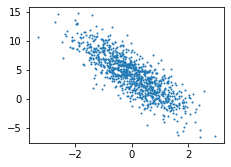

In [7]:
# def set_figsize(figsize=(3.5, 2.5)):
#     plt.rcParams['figure.figsize'] = figsize
    
# set_figsize()
plt.scatter(features[:,1], labels, 1)

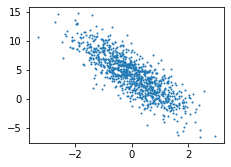

In [8]:
def set_figsize(figsize=(3.5, 2.5)):
    plt.rcParams['figure.figsize'] = figsize
    
set_figsize()
plt.scatter(features[:,1], labels, 1)

In [9]:
plt.scatter??

In [12]:
tf.gather??

## 3.2.2 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回`batch_size`（批量大小）个随机样本的特征和标签。

In [24]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)   # 随机打乱其顺序
    for i in range(0, num_examples, batch_size):
        j = indices[i:min(i+ batch_size, num_examples)]  # 打乱顺序的索引
        yield tf.gather(features, axis=0, indices=j), tf.gather(labels, axis = 0, indices=j)
        

tf.gather(params,indices,axis=0 )

从params的  axis维  根据  indices的参数值  获取切片

In [22]:
def foo():
    print("starting...")
    while True:
        res = yield 4     # yield ,反悔这个值，并且停留在这个位置，下一个 next 从下一行代码开始执行
        res = 1
        print("res:",res)
g = foo()
print(next(g))
print("*" * 30)
print(next(g))

starting...
4
******************************
res: 1
4


让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [25]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tf.Tensor(
[[ 1.745217   -0.8350987 ]
 [ 0.9189912   0.39529774]
 [-0.37226713 -1.8647166 ]
 [-0.35306954  1.4921232 ]
 [ 0.30183843  0.21430783]
 [ 0.29339626  0.10990765]
 [-0.20913956  0.77864856]
 [-0.49458995 -0.76829404]
 [-1.1162287   0.47509938]
 [ 0.40614483 -1.0056064 ]], shape=(10, 2), dtype=float32) tf.Tensor(
[10.19376     4.853099    9.057921   -0.99189603  4.146182    4.4523807
  1.4465337   5.5164046   0.54145044  8.021297  ], shape=(10,), dtype=float32)


## 3.2.3 初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [38]:
w = tf.Variable(tf.random.normal((num_inputs, 1), stddev = 0.01))
b = tf.Variable(tf.zeros((1,)))

## 3.2.4 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用`matmul`函数做矩阵乘法。

In [34]:
def linreg(X, w,b):
    return tf.matmul(X, w) + b

## 3.2.5 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值`y`变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。

In [31]:
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y,y_hat.shape)) **2 /2
# tf.reshape 的用法

## 3.2.6 定义优化算法

以下的`sgd`函数实现了上一节中介绍的小批量随机梯度下降算法。它**通过不断迭代模型参数来优化损失函数**。这里**自动求梯度模块计算得来的梯度是一个批量样本的梯度和**。我们将它除以批量大小来得到平均值。



In [32]:
def sgd(params, lr, batch_size, grads):
    "小批量随机梯度下降算法"
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i] / batch_size)
    

## 3.2.7 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`t.gradients`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为10，每个小批量的损失`l`的形状为(10, 1)。回忆一下自动求梯度一节。由于变量`l`并不是一个标量，所以我们可以调用`reduce_sum()`将其求和得到一个标量，再运行`t.gradients`得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [39]:
lr = 0.03 # 学习率
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as t:
            t.watch([w,b])
            l = tf.reduce_sum(loss(net(X,w,b),y)) #损失函数
        grads = t.gradient(l, [w,b]) # 损失函数对于 w ,b 求导
        sgd([w,b], lr, batch_size, grads) # 更新参数
    train_l = loss(net(features,w,b), labels) # 用训练好的参数去计算训练集的误差
    print('epoch %d, loss %f' % (epoch+1, tf.reduce_mean(train_l)))

epoch 1, loss 0.046717
epoch 2, loss 0.000204
epoch 3, loss 0.000050


训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。

In [41]:
print(true_w, w)
print(true_b, b)

[2, -3, 4] <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 1.9991968],
       [-2.9993627]], dtype=float32)>
4.2 <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([4.199113], dtype=float32)>


## 小结

* 可以看出，仅使用`Variables`和`GradientTape`模块就可以很容易地实现一个模型。接下来，本书会在此基础上描述更多深度学习模型，并介绍怎样使用更简洁的代码（见下一节）来实现它们。

-----------

> 注：本节除了代码之外与原书基本相同，[原书传送门](